In [11]:
%load_ext autoreload
%autoreload 2
#%pip list

import sys
#from gensim.utils import tokenize
import pandas as pd
import numpy as np
import re
import transformers
from sklearn.preprocessing import LabelEncoder
import os
import re
from utils import *
import plotly.express as px
import plotly.graph_objects as go
import torch
import torch.nn as nn
import sys
import string
import logging
import torch.optim as optim
import random
import torchtext
import matplotlib.pyplot as plt



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset



class customTextDataset(Dataset):
    def __init__(self, path, colnames, maxLen, tokenizer=None): 
        self.data =  pd.read_csv(path, names=colnames, header=None, sep = ',', index_col=False)
        self.tokenizer = tokenizer
        self.maxLen = maxLen


    def __getitem__(self, idx):
        #To do{
        # indent below with if vocab == None: return sentence, label
        # if vocab is Not none, return tokens, labels
        #}
        sentence = remove_tags(self.data.loc[idx].text)
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
        sentence = re.sub(r'\s+', ' ', sentence)
        sentence = sentence.lower()
        sentence = self.tokenizer(sentence,    padding='max_length', truncation=True,max_length=self.maxLen)['input_ids']

        label = remove_tags(self.data.loc[idx].food)
        label = re.sub('[^a-zA-Z]', ' ', label)
        label = re.sub(r"\s+[a-zA-Z]\s+", ' ', label)
        label = re.sub(r'\s+', ' ', label)
        label = label.lower()
        return torch.tensor(sentence),label
 

    def __len__(self):
        return len(self.data)

    def getHead(self):
        print(self.data.head())

In [13]:
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer
maxLen = 32
batchSize = 512

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

#print(tokenizer('[PAD]'))
#print(tokenizer(tokenizer.pad_token)['input_ids'][0])

trainData = customTextDataset(path = 'train_titles.csv', colnames=['image_path', 'text', 'food'], tokenizer = tokenizer,maxLen=maxLen)
trainLoader = DataLoader(trainData,batch_size=batchSize,shuffle=True)
print(f'Number of train samples  = {trainData.__len__()}')
trainData.getHead()
testData = customTextDataset(path = 'test_titles.csv', colnames=['image_path', 'text', 'food'], tokenizer = tokenizer,maxLen=maxLen)
testLoader = DataLoader(testData,batch_size=batchSize,shuffle=True)
print(f"Number of test data points = {testData.__len__()}")

Number of train samples  = 67972
          image_path                                               text  \
0  apple_pie_851.jpg    Crock-Pot Ladies  Crock-Pot Apple Pie Moonshine   
1  apple_pie_140.jpg       Mom's Maple-Apple Pie Recipe | Taste of Home   
2  apple_pie_858.jpg  Cookin&#8217; Canuck &#8211; Baked Apple Pie E...   
3  apple_pie_449.jpg      Dutch Apple Pie Recipe | Just A Pinch Recipes   
4  apple_pie_695.jpg  Our Share of the Harvest &raquo; Grandma&#8217...   

        food  
0  apple_pie  
1  apple_pie  
2  apple_pie  
3  apple_pie  
4  apple_pie  
Number of test data points = 22716


In [14]:
data = next(iter(trainLoader))
print(data[0][0:2])
print(data[1][0:2])

tensor([[   69,  3532, 21670, 17141, 29777,  8364, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257],
        [   70, 10316, 20698,  8364,   308,   688, 20766, 36167,   680, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257]])
('french onion soup', 'greek salad')


In [15]:
labelsTrain_ = []
for data in trainLoader:
    labelsTrain_ = labelsTrain_ + (list(data[1]))
  
from collections import Counter
labelsDict = Counter(labelsTrain_)
keys = labelsDict.keys()
lblMap = {x:i for i,x in enumerate(keys)}

In [16]:
class w2nModel(torch.nn.Module):
    def __init__(self,vocab_size, embedding_dim, hidden_size, nClasses, padId):
        super(w2nModel, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.LSTM = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_size,batch_first=True)
        #self.bn = nn.BatchNorm1d(hidden_size)
        self.drop1 = nn.Dropout(p = 0.5)
        self.FC1 = nn.Linear(hidden_size,256)
        self.drop2 = nn.Dropout(p = 0.5)
        self.FC2 = nn.Linear(256,nClasses)
        self.Relu = torch.nn.ReLU()
        self.padId = padId

    def forward(self, x_):
        x = self.word_embeddings(x_) # input dimensions are (batch size, sqeuenquence length) - output dimensions are (batch size, sequence length, feature size)
        x[x_ == self.padId,:] = 0 # set rows, where each row is of dimension equal to feature size, corresponding to pad id = 0
        (x,_) = self.LSTM(x)        
        x = x[:, -1, :] # gives two dimensional output, not three dimensional output -  we are retaining the last hidden state                        
        x = self.drop1(x)               
        x = self.Relu(self.FC1(x))
        x = self.drop2(x)
        x = self.FC2(x)
        return x

### Train Neural Net

In [17]:
import numpy
from transformers import GPT2Config

torch.device('cuda:0')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
hidden_size = 64
padId = tokenizer(tokenizer.pad_token)['input_ids'][0]
dModel = 100
config = GPT2Config()
vocabSize = config.vocab_size
numClasses = 101
model = w2nModel(vocab_size = vocabSize+1, 
                 embedding_dim = dModel,
                 hidden_size=hidden_size, nClasses = numClasses, padId = padId
                )

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.005)
lossVals = []
model = model.to(device)
print(model)

cpu
w2nModel(
  (word_embeddings): Embedding(50258, 100)
  (LSTM): LSTM(100, 64, batch_first=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (FC1): Linear(in_features=64, out_features=256, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (FC2): Linear(in_features=256, out_features=101, bias=True)
  (Relu): ReLU()
)


In [18]:
for epoch in range(35):  # loop over the dataset multiple times
    for data in trainLoader:
        inputs = data[0]
        labels_ = data[1]
        labels = []
        labels.append([lblMap[x] for x in labels_])
        labels = torch.tensor(labels[0])
        #inputs = inputs.to(device) 
        #labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        lossVals.append(loss.detach().clone().cpu())
        optimizer.step()
    if epoch%1 == 0:
        print(loss)
print('Finished Training')

tensor(4.6007, grad_fn=<NllLossBackward0>)
tensor(4.4502, grad_fn=<NllLossBackward0>)
tensor(3.6048, grad_fn=<NllLossBackward0>)
tensor(2.2170, grad_fn=<NllLossBackward0>)
tensor(1.4574, grad_fn=<NllLossBackward0>)
tensor(1.4978, grad_fn=<NllLossBackward0>)
tensor(0.9402, grad_fn=<NllLossBackward0>)
tensor(0.9949, grad_fn=<NllLossBackward0>)
tensor(0.9300, grad_fn=<NllLossBackward0>)
tensor(1.1220, grad_fn=<NllLossBackward0>)
tensor(0.9148, grad_fn=<NllLossBackward0>)
tensor(0.7748, grad_fn=<NllLossBackward0>)
tensor(0.8214, grad_fn=<NllLossBackward0>)
tensor(0.7450, grad_fn=<NllLossBackward0>)
tensor(0.8533, grad_fn=<NllLossBackward0>)
tensor(0.7753, grad_fn=<NllLossBackward0>)
tensor(0.8384, grad_fn=<NllLossBackward0>)
tensor(0.7501, grad_fn=<NllLossBackward0>)
tensor(0.7401, grad_fn=<NllLossBackward0>)
tensor(0.6852, grad_fn=<NllLossBackward0>)
tensor(0.6750, grad_fn=<NllLossBackward0>)
tensor(0.6781, grad_fn=<NllLossBackward0>)
tensor(0.7490, grad_fn=<NllLossBackward0>)
tensor(0.58

# Test Neural Net

In [19]:
# again no gradients needed
model.eval()
correct_pred = 0
numTst = 0
with torch.no_grad():
    for data in testLoader:
        numTst = numTst + inputs.shape[0]
        inputs, labels_ = data
        labels = []
        labels.append([lblMap[x] for x in labels_])
        labels = torch.tensor(labels[0])

        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred += 1


accuracy = 100 * float(correct_pred)/ numTst
print(numTst)
print(f"Classification Accuracy is {accuracy}%")

22916
Classification Accuracy is 82.17402688078198%


RuntimeError: Numpy is not available

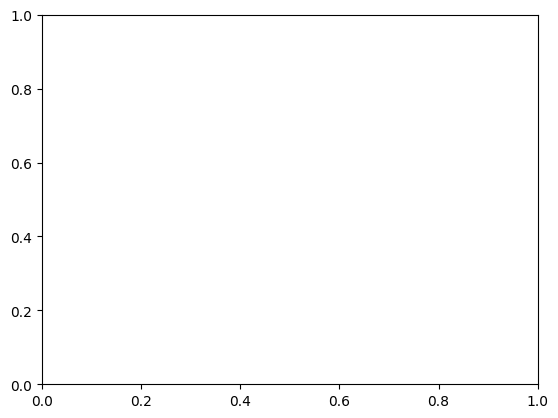

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols=1)
ax.plot(range(len(lossVals)),lossVals)
ax.set_xlabel('Iterations',fontsize = 15)
ax.set_ylabel('Cross Entropy Loss', fontsize = 15)
ax.set_title('Classification Accuracy = {:.2f}%'.format(accuracy),fontsize = 15)
path = 'dim_{}_accry_{:.2f}len_{}_hidden_{}'.format(dim,accuracy, maxLen,hidden_size)
plt.savefig(path+'.pdf')

### Get 5 Most Error-Full Classes

In [ ]:
path = os.getcwd()
checkpoint_path = path+'\_accrcy_{:.2f}_dim_{}.pt'.format(accuracy,dim)
print(checkpoint_path)
torch.save(model, checkpoint_path)

# SVM with LSTM

### Declare LSTM model

In [ ]:
class w2nModelSVM(torch.nn.Module):
    def __init__(self,vocab_size, embedding_dim, hidden_size, nClasses):
        super(w2nModelSVM, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.LSTM = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_size,batch_first=True)

    def forward(self, x):
        x = self.word_embeddings(x)     # output dimensions is batch size = N x sequence length x feature size
        (x,_) = self.LSTM(x)        
        x = x[:, -1, :]                 # gives two dimensional output, not three dimensional output
        return x

torch.device('cuda:0')
modelSVM = w2nModelSVM(vocab_size = w2v_weights.shape[0], 
                 embedding_dim = w2v_weights.shape[1],
                 hidden_size=hidden_size, nClasses = numClasses
                )
modelSVM.word_embeddings.weight.data.copy_(torch.from_numpy(w2v_weights))
modelSVM.word_embeddings.weight.requires_grad=False
modelSVM.LSTM.load_state_dict(model.LSTM.state_dict())
modelSVM.LSTM.requires_grad_=False

### Get LSTM Embeddings for Train and Test Dataset

In [ ]:
labels_train = torch.tensor(encoded_labels_train).long()
trainloader = torch.utils.data.DataLoader(list(zip(idsTrn.int(), labels_train)), batch_size=batchSize,
                                         shuffle=True)
trnEmbdngs = np.zeros((idsTrn.shape[0],hidden_size))
trnLbls  = np.zeros((idsTrn.shape[0]))
for i, data in enumerate(trainloader):
    inputs,labels = data
    outputs = modelSVM(inputs)
    trnEmbdngs[i*batchSize: (i+1)*batchSize,:] = outputs.detach().clone().numpy()
    trnLbls[i*batchSize: (i+1)*batchSize] = labels

labels_test = torch.tensor(encoded_labels_test).long()
trainloader = torch.utils.data.DataLoader(list(zip(idsTst.int(), labels_test)), batch_size=batchSize,
                                         shuffle=True)
tstEmbdngs = np.zeros((idsTst.shape[0],hidden_size))
tstLbls  = np.zeros((idsTst.shape[0]))
for i, data in enumerate(trainloader):
    inputs,labels = data
    outputs = modelSVM(inputs)
    tstEmbdngs[i*batchSize: (i+1)*batchSize,:] = outputs.detach().clone().numpy()
    tstLbls[i*batchSize: (i+1)*batchSize] = labels

### Linear SVM


In [ ]:
from sklearn import svm
clf = svm.SVC(decision_function_shape='ovo', kernel = 'linear')
clf.fit(trnEmbdngs, trnLbls)
TrnAccrcyLnr = clf.score(trnEmbdngs, trnLbls)
TstAccrcyLnr = clf.score(tstEmbdngs,tstLbls)
print(r'Train Accuracy of Linear SVM =', TrnAccrcyLnr)
print(TstAccrcyLnr)

### RBF Kernel SVM

In [ ]:
clf = svm.SVC(decision_function_shape='ovo', kernel='rbf')
clf.fit(trnEmbdngs, trnLbls)
TrnAccrcyKernel = clf.score(trnEmbdngs, trnLbls)
TstAccrcyKernel = clf.score(tstEmbdngs,tstLbls)
print(TrnAccrcyKernel)
print(TstAccrcyKernel)

# SVM without LSTM - Averaging Word2Vec Embeddings

In [ ]:
class w2nModelSVM(torch.nn.Module):
    def __init__(self,vocab_size, embedding_dim, hidden_size, nClasses):
        super(w2nModelSVM, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, x):
        x = self.word_embeddings(x)                # output dimensions is batch size = N x sequence length x feature size
        x = torch.sum(x,dim=1)/x.shape[1]          # batch size x feature size
        return x

torch.device('cuda:0')
modelw2vAvg = w2nModelSVM(vocab_size = w2v_weights.shape[0], 
                 embedding_dim = w2v_weights.shape[1],
                 hidden_size=hidden_size, nClasses = numClasses
                )
modelw2vAvg.word_embeddings.weight.data.copy_(torch.from_numpy(w2v_weights))
modelw2vAvg.word_embeddings.weight.requires_grad=False


In [ ]:
labels_train = torch.tensor(encoded_labels_train).long()
trainloader = torch.utils.data.DataLoader(list(zip(idsTrn.int(), labels_train)),
                                         batch_size=batchSize,
                                         shuffle=True)
trnEmbdngs = np.zeros((idsTrn.shape[0],dim))
trnLbls  = np.zeros((idsTrn.shape[0]))
for i, data in enumerate(trainloader):
    inputs,labels = data
    outputs = modelw2vAvg(inputs)
    trnEmbdngs[i*batchSize: (i+1)*batchSize,:] = outputs.detach().clone().numpy()
    trnLbls[i*batchSize: (i+1)*batchSize] = labels

labels_test = torch.tensor(encoded_labels_test).long()
trainloader = torch.utils.data.DataLoader(list(zip(idsTst.int(), labels_test)), batch_size=batchSize,
                                         shuffle=True)
tstEmbdngs = np.zeros((idsTst.shape[0],dim))
tstLbls  = np.zeros((idsTst.shape[0]))
for i, data in enumerate(trainloader):
    inputs,labels = data
    outputs = modelw2vAvg(inputs)
    tstEmbdngs[i*batchSize: (i+1)*batchSize,:] = outputs.detach().clone().numpy()
    tstLbls[i*batchSize: (i+1)*batchSize] = labels

In [ ]:
clf = svm.SVC(decision_function_shape='ovo', kernel = 'linear')
clf.fit(trnEmbdngs, trnLbls)
TrnAccrcyLnr = clf.score(trnEmbdngs, trnLbls)
TstAccrcyLnr = clf.score(tstEmbdngs,tstLbls)
print(TrnAccrcyLnr)
print(TstAccrcyLnr)

In [ ]:
clf = svm.SVC(decision_function_shape='ovo', kernel='rbf')
clf.fit(trnEmbdngs, trnLbls)
TrnAccrcyKernel = clf.score(trnEmbdngs, trnLbls)
TstAccrcyKernel = clf.score(tstEmbdngs,tstLbls)
print(TrnAccrcyKernel)
print(TstAccrcyKernel)